In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [196]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [197]:
RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(7)
np.random.seed(42)
tf.random.set_seed(42)

In [198]:
# Load the xlsx file
excel_data = pd.read_excel('data_gdp_coordinates.xlsx')
# Read the values of the file in the dataframe
data = pd.DataFrame(excel_data)
del data["Unnamed: 0"]
data.describe()

,Ano,GDP,Lat,Lon
count,16226.000000,1.284000e+04,10980.000000,10980.000000
mean,1990.000000,1.125492e+12,18.770526,15.593089
std,17.607359,5.057450e+12,24.809407,70.798236
min,1960.000000,8.824448e+06,-40.900557,-175.198242
25%,1975.000000,2.366667e+09,2.814784,-11.150599
50%,1990.000000,1.755694e+10,17.450761,18.687854
75%,2005.000000,2.113418e+11,40.223245,46.366989
max,2020.000000,8.756805e+13,71.706936,179.414413


In [199]:
data.notna().sum()

Pais    16226
Ano     16226
GDP     12840
Lat     10980
Lon     10980
dtype: int64

In [200]:
all_data=data.dropna(subset=['Lat','Lon'])

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


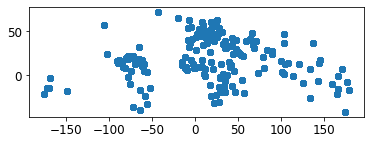

In [201]:
# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(all_data['Lon'], all_data['Lat'])]
geo_df = gpd.GeoDataFrame(all_data, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
geo_df.plot()

In [202]:
del all_data['geometry']
colunas = all_data.columns.tolist()

In [203]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    # for x in unique_list:
    #     print (x)
    return unique_list
lista_unica = unique(all_data['Pais'].tolist())       
# all_data['Pais'].tolist()

In [204]:
all_data

,Pais,Ano,GDP,Lat,Lon
0,Aruba,1960,NaN,12.521110,-69.968338
1,Aruba,1961,NaN,12.521110,-69.968338
2,Aruba,1962,NaN,12.521110,-69.968338
3,Aruba,1963,NaN,12.521110,-69.968338
4,Aruba,1964,NaN,12.521110,-69.968338
...,...,...,...,...,...
16221,Zimbabwe,2016,2.054868e+10,-19.015438,29.154857
16222,Zimbabwe,2017,1.758489e+10,-19.015438,29.154857
16223,Zimbabwe,2018,1.811554e+10,-19.015438,29.154857
16224,Zimbabwe,2019,1.928429e+10,-19.015438,29.154857


In [205]:
import math
dataset = []
for pais in lista_unica:
   data_pais = all_data[all_data["Pais"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha:linha+1]
     gdp_2 = gdp[linha+1:linha+2]
     gdp_3 = gdp[linha+2:linha+3]
     gdp_4 = gdp[linha+3:linha+4]
     gdp_5 = gdp[linha+4:linha+5]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1[0]) or math.isnan(gdp_2[0]) or math.isnan(gdp_3[0]) or math.isnan(gdp_4[0]) or math.isnan(gdp_5[0]):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais])
       dataset.append([longitude_pais])
       dataset.append(gdp_1)
       dataset.append(gdp_2)
       dataset.append(gdp_3)
       dataset.append(gdp_4)
       dataset.append(gdp_5)

      
      # dataset.append(dataset_array)
     linha +=4

print(dataset)    


[[12.52111], [-69.968338], [596423607.114715], [695304363.031101], [764887117.194486], [872138715.083799], [958463184.357542], [12.52111], [-69.968338], [958463184.357542], [1082979720.67039], [1245688268.15642], [1320474860.3352], [1379960893.85475], [12.52111], [-69.968338], [1379960893.85475], [1531944134.07821], [1665100558.65922], [1722798882.68156], [1873452513.96648], [12.52111], [-69.968338], [1873452513.96648], [1920111731.84358], [1941340782.12291], [2021229050.27933], [2228491620.11173], [12.52111], [-69.968338], [2228491620.11173], [2330726256.98324], [2424581005.58659], [2615083798.88268], [2745251396.64804], [12.52111], [-69.968338], [2745251396.64804], [2498882681.56425], [2390502793.29609], [2549720670.39106], [2534636871.50838], [12.52111], [-69.968338], [2534636871.50838], [2727849720.67039], [2790849162.01117], [2962905027.93296], [2983636871.50838], [33.93911], [67.709953], [537777811.111111], [548888895.555556], [546666677.777778], [751111191.111111], [800000044.44

In [206]:
import math
dataset = []
for pais in lista_unica:
   data_pais = all_data[all_data["Pais"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

      
      # dataset.append(dataset_array)
     linha +=4

print(dataset)    


[[12.52111, -69.968338, 596423607.114715, 695304363.031101, 764887117.194486, 872138715.083799, 958463184.357542], [12.52111, -69.968338, 958463184.357542, 1082979720.67039, 1245688268.15642, 1320474860.3352, 1379960893.85475], [12.52111, -69.968338, 1379960893.85475, 1531944134.07821, 1665100558.65922, 1722798882.68156, 1873452513.96648], [12.52111, -69.968338, 1873452513.96648, 1920111731.84358, 1941340782.12291, 2021229050.27933, 2228491620.11173], [12.52111, -69.968338, 2228491620.11173, 2330726256.98324, 2424581005.58659, 2615083798.88268, 2745251396.64804], [12.52111, -69.968338, 2745251396.64804, 2498882681.56425, 2390502793.29609, 2549720670.39106, 2534636871.50838], [12.52111, -69.968338, 2534636871.50838, 2727849720.67039, 2790849162.01117, 2962905027.93296, 2983636871.50838], [33.93911, 67.709953, 537777811.111111, 548888895.555556, 546666677.777778, 751111191.111111, 800000044.444444], [33.93911, 67.709953, 800000044.444444, 1006666637.77778, 1399999966.66667, 1673333417.77

In [207]:
my_array = np.array(dataset)
dataset = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [208]:
# lista=[]
# data=[]
# contador=0
# for l in dataset:
#   # print(l[0])
#   lista.append([l[0]])
#   contador +=1
#   if contador ==7:
#     # print(lista)
#     data.append(lista)
#     lista=[]
#     contador=0
  
# my_array = np.array(data)
# dataset = my_array.astype('float32')
# # dataset

In [209]:
n_steps = 6 #CADA LISTA DENTRO DA LISTA VAI TER 7 DADOS

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

In [210]:
X_train

array([[4.7440594e-01, 2.9674602e-01, 5.2227075e-05, 5.5698729e-05,
        5.4264896e-05, 6.0302325e-05],
       [4.7440594e-01, 2.9674602e-01, 8.4456304e-05, 8.7190427e-05,
        8.8867841e-05, 9.1698581e-05],
       [4.7440594e-01, 2.9674602e-01, 1.2197857e-04, 1.2366076e-04,
        1.1905266e-04, 1.1987267e-04],
       ...,
       [0.0000000e+00, 9.8722982e-01, 2.0683925e-03, 1.9827129e-03,
        1.7383270e-03, 1.7015671e-03],
       [0.0000000e+00, 9.8722982e-01, 1.9278660e-03, 2.0040101e-03,
        2.2018142e-03, 2.8267184e-03],
       [0.0000000e+00, 9.8722982e-01, 4.0208311e-03, 3.5669513e-03,
        3.2734706e-03, 2.9926139e-03]], dtype=float32)

In [211]:
X_train.shape, y_train.shape

((1435, 6), (1435,))

Saving figure time_series_plot


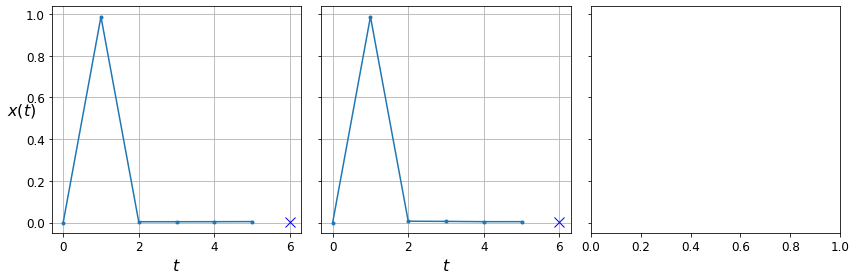

In [227]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    # plt.hlines(0, 0, 100, linewidth=1)
    # plt.axis([0, n_steps + 1, -1, 1])


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(2):
    plt.sca(axes[col])
    plot_series(
        X_valid[col, :],
        y_valid[col],
        y_label=("$x(t)$" if col == 0 else None),
    )
save_fig("time_series_plot")
plt.show()

In [228]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

7.7718937e-07

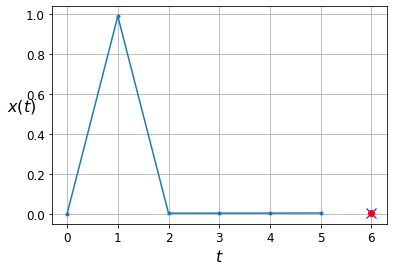

In [229]:
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

In [231]:


model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
12/12 [==============================] - 1s 26ms/step - loss: 0.0772 - val_loss: 0.0144
Epoch 2/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0169 - val_loss: 0.0034
Epoch 3/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0037
Epoch 4/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0019
Epoch 5/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 6/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 7/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 8/80
12/12 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/80
12/12 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/80
12/12 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 11/80
12/12 

In [232]:
model.evaluate(X_valid, y_valid) #Erro medio quadratico

13/13 [==============================] - 0s 2ms/step - loss: 2.0576e-06


2.0576082988554845e-06

In [233]:
model.layers[0].get_weights()

[array([[ 0.00087877],
        [ 0.00231711],
        [-0.2836529 ],
        [ 0.28025216],
        [ 0.5968861 ],
        [ 0.438068  ]], dtype=float32), array([-0.00192133], dtype=float32)]

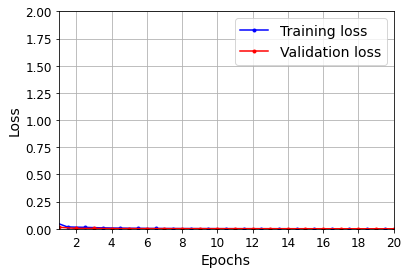

In [234]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(
        np.arange(len(val_loss)) + 1,
        val_loss,
        "r.-",
        label="Validation loss",
    )
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

13/13 [==============================] - 0s 1ms/step


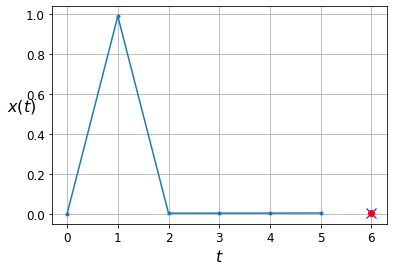

In [236]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

Simple RNN

In [237]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])

In [238]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [239]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=20, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
72/72 [==============================] - 1s 6ms/step - loss: 0.0187 - val_loss: 0.0027
Epoch 2/80
72/72 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/80
72/72 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.0467e-04
Epoch 4/80
72/72 [==============================] - 0s 3ms/step - loss: 5.6282e-04 - val_loss: 3.3596e-04
Epoch 5/80
72/72 [==============================] - 0s 3ms/step - loss: 3.5217e-04 - val_loss: 2.2155e-04
Epoch 6/80
72/72 [==============================] - 0s 4ms/step - loss: 2.7262e-04 - val_loss: 1.6484e-04
Epoch 7/80
72/72 [==============================] - 0s 3ms/step - loss: 2.3992e-04 - val_loss: 1.3589e-04
Epoch 8/80
72/72 [==============================] - 0s 3ms/step - loss: 2.2588e-04 - val_loss: 1.2148e-04
Epoch 9/80
72/72 [==============================] - 0s 3ms/step - loss: 2.0874e-04 - val_loss: 1.0408e-04
Epoch 10/80
72/72 [==============================] - 0s 3ms/step -

In [240]:
model.evaluate(X_valid, y_valid) #

13/13 [==============================] - 0s 2ms/step - loss: 1.5871e-06


1.5870651850491413e-06

In [241]:
model.layers[0].get_weights()

[array([[0.9857287]], dtype=float32),
 array([[0.08207893]], dtype=float32),
 array([-0.00066941], dtype=float32)]

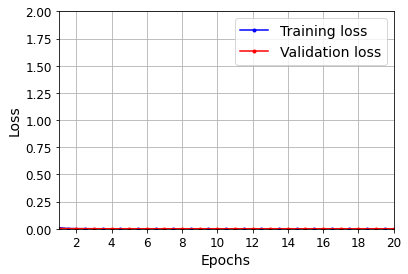

In [242]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

13/13 [==============================] - 0s 2ms/step


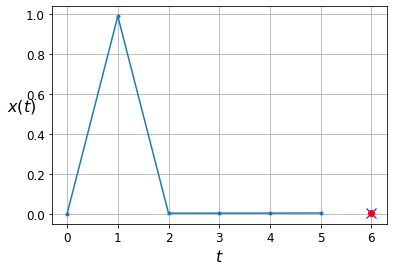

In [244]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()